In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('../data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('../data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('../data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('../data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('../data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [8]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [9]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params

In [10]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [11]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True,
                  
                    }
        return params

In [12]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.get_feature_names()]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/paniquex/anaconda3/envs/kaggle/lib

In [13]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.get_feature_names()]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(200, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [14]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode

train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0.0026939774600629332


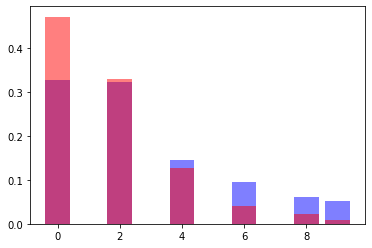

0.0026939774600629332

In [15]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [16]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [17]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 0.9999999999999974
2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434877979
3: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.9999839030068794
4: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966123918733648
5: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.996508454399599
6: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965259434877979
7: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
8: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998050146714084
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068794
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.996508454399599
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146714084
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434877979
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733648
15: FEAT_A: 3110 FEAT_B: 3010 - Correlation: 

110: FEAT_A: b2dba42b FEAT_B: 1bb5fbdb - Correlation: 0.9999521729414085
111: FEAT_A: b2dba42b FEAT_B: Sandcastle Builder (Activity)_3110 - Correlation: 0.9999521729414085
112: FEAT_A: b2dba42b FEAT_B: Sandcastle Builder (Activity)_3010 - Correlation: 0.999999999999937
113: FEAT_A: d3640339 FEAT_B: Dino Dive_4090 - Correlation: 1.0
114: FEAT_A: 56bcd38d FEAT_B: Chicken Balancer (Activity)_4030 - Correlation: 1.0
115: FEAT_A: 89aace00 FEAT_B: e5734469 - Correlation: 0.9998406115109634
116: FEAT_A: 89aace00 FEAT_B: Dino Drink_3120 - Correlation: 1.0
117: FEAT_A: 89aace00 FEAT_B: Dino Drink_3020 - Correlation: 0.9998406115109634
118: FEAT_A: 7dfe6d8a FEAT_B: Leaf Leader_4070 - Correlation: 1.0
119: FEAT_A: 5d042115 FEAT_B: Flower Waterer (Activity)_4030 - Correlation: 0.9999999999999896
120: FEAT_A: d2e9262e FEAT_B: 2fb91ec1 - Correlation: 0.9991434495208379
121: FEAT_A: d2e9262e FEAT_B: Watering Hole (Activity)_4025 - Correlation: 0.9991434495208379
122: FEAT_A: d2e9262e FEAT_B: Watering

215: FEAT_A: 7423acbc FEAT_B: e04fb33d - Correlation: 0.9996289974081646
216: FEAT_A: 7423acbc FEAT_B: Air Show_3020 - Correlation: 0.9999999999999707
217: FEAT_A: 7423acbc FEAT_B: Air Show_3120 - Correlation: 0.9996289974081646
218: FEAT_A: 2ec694de FEAT_B: Bug Measurer (Activity)_4080 - Correlation: 1.0
219: FEAT_A: a0faea5d FEAT_B: Bubble Bath_4070 - Correlation: 1.0
220: FEAT_A: d2659ab4 FEAT_B: Air Show_2075 - Correlation: 0.9999999999999927
221: FEAT_A: 6aeafed4 FEAT_B: Bubble Bath_4090 - Correlation: 1.0
222: FEAT_A: e7561dd2 FEAT_B: Pan Balance_4025 - Correlation: 1.0
223: FEAT_A: 28520915 FEAT_B: b5053438 - Correlation: 0.9990905166101242
224: FEAT_A: 28520915 FEAT_B: d3268efa - Correlation: 0.9989055023165085
225: FEAT_A: 28520915 FEAT_B: Cauldron Filler (Assessment)_2030 - Correlation: 1.0
226: FEAT_A: 28520915 FEAT_B: Cauldron Filler (Assessment)_3121 - Correlation: 0.9990905166101242
227: FEAT_A: 28520915 FEAT_B: Cauldron Filler (Assessment)_3021 - Correlation: 0.998905502

320: FEAT_A: 36fa3ebe FEAT_B: Happy Camel_3121 - Correlation: 0.9979559120624222
321: FEAT_A: 36fa3ebe FEAT_B: Happy Camel_3021 - Correlation: 0.9998350234117185
322: FEAT_A: 795e4a37 FEAT_B: Cart Balancer (Assessment)_3010 - Correlation: 0.9999999999999821
323: FEAT_A: a16a373e FEAT_B: Bird Measurer (Assessment)_4070 - Correlation: 0.9999999999999803
324: FEAT_A: 3ee399c3 FEAT_B: Cauldron Filler (Assessment)_4070 - Correlation: 1.0
325: FEAT_A: f54238ee FEAT_B: Fireworks (Activity)_4090 - Correlation: 1.0
326: FEAT_A: 828e68f9 FEAT_B: Cart Balancer (Assessment)_3110 - Correlation: 1.0
327: FEAT_A: 611485c5 FEAT_B: Fireworks (Activity)_4080 - Correlation: 1.0
328: FEAT_A: 0413e89d FEAT_B: 15eb4a7d - Correlation: 0.9997266832893213
329: FEAT_A: 0413e89d FEAT_B: Bubble Bath_3110 - Correlation: 0.9997266832893213
330: FEAT_A: 0413e89d FEAT_B: Bubble Bath_3010 - Correlation: 0.9999999999999544
331: FEAT_A: 29f54413 FEAT_B: Leaf Leader_2060 - Correlation: 1.0
332: FEAT_A: 756e5507 FEAT_B: C

423: FEAT_A: 3bfd1a65 FEAT_B: db02c830 - Correlation: 0.9999982205265163
424: FEAT_A: 3bfd1a65 FEAT_B: Mushroom Sorter (Assessment)_2000 - Correlation: 1.0
425: FEAT_A: 3bfd1a65 FEAT_B: Mushroom Sorter (Assessment)_2025 - Correlation: 0.9999982205265163
426: FEAT_A: 8d84fa81 FEAT_B: Bubble Bath_4010 - Correlation: 0.9999999999999376
427: FEAT_A: 30df3273 FEAT_B: Sandcastle Builder (Activity)_4080 - Correlation: 1.0
428: FEAT_A: 0086365d FEAT_B: Pan Balance_4010 - Correlation: 0.9999999999999705
429: FEAT_A: c952eb01 FEAT_B: Watering Hole (Activity)_4070 - Correlation: 1.0
430: FEAT_A: bd701df8 FEAT_B: 49ed92e9 - Correlation: 0.999310913888882
431: FEAT_A: bd701df8 FEAT_B: Watering Hole (Activity)_3010 - Correlation: 0.999310913888882
432: FEAT_A: bd701df8 FEAT_B: Watering Hole (Activity)_3110 - Correlation: 1.0
433: FEAT_A: 5e3ea25a FEAT_B: Crystals Rule_4070 - Correlation: 1.0
434: FEAT_A: c2baf0bd FEAT_B: Happy Camel_2020 - Correlation: 0.9999999999999991
435: FEAT_A: 6043a2b4 FEAT_B

In [18]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346 0.006732930476733109
29a42aea 0.004070096099491238 0.0
7fd1ac25 0.01978518937252685 0.0
119b5b02 0.0002826455624646693 0.0
2ec694de 0.008988128886376484 0.0
6aeafed4 0.14703222159412097 0.008 0.0
0ce40006 0.0008479366873940079 0.0
003cd2ee 0.0 0.0
611485c5 0.0013566986998304127 0.0
ecc6157f 0.007292255511588468 0.0
01ca3a3c 0.0004522328999434709 0.0
bfc77bd6 0.012832108535895986 0.0
ab4ec3a4 0.0009044657998869418 0.0
13f56524 0.04392312040700961 0.0
4074bac2 0.0 0.0
5dc079d8 0.0 0.0
a8cc6fec 0.0 0.0
1b54d27f 0.0007348784624081402 0.0
e4d32835 0.0013001695873374789 0.0
eb2c19cd 0.17382702091577162 0.008 0.0
dcb1663e 0.0 0.0
17ca3959 0.0 0.0
Watering Hole (Activity)_2010 0.0007348784624081402 0.0
Mushroom Sorter (Assessment)_4080 0.04392312040700961 0.0
Mushroom Sorter (Assessment)_4090 0.17382702091577162 0.008 0.0
Bubble Bath_4090 0.14703222159412097 0.008 0.0
Egg Dropper (Activity)_4080 0.01978518937252685 0.0
Pa

In [19]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(17690, 365)

In [20]:
pseudolabels = pd.read_csv('for_pseudolabeling.csv', index_col=0)

reduce_train = pd.concat([reduce_train, reduce_test], axis=0, sort=True).reset_index().drop(columns='index')

In [21]:
np.argmax(reduce_train.columns == 'accuracy_group')

894

In [22]:
reduce_train.iloc[-1000:, 894] = np.mean(pseudolabels.values, axis=1)

In [23]:
reduce_train['accuracy_group']

0        3.000000
1        0.000000
2        3.000000
3        2.000000
4        3.000000
           ...   
18685    2.546667
18686    0.626667
18687    2.106667
18688    1.486667
18689    1.490000
Name: accuracy_group, Length: 18690, dtype: float64

In [24]:
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]

features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]
categoricals = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in categoricals]

In [25]:
coefs = [1.2641475186120315, 1.7026714246402963, 1.9379324492578078]

def soft2hard(o):
    if o < coefs[0]: return 0
    elif o < coefs[1]: return 1
    elif o < coefs[2]: return 2
    else: return 3
    
_targs = np.array([soft2hard(o.item()) for o in reduce_train.iloc[-1000:, 894].values])

In [26]:
reduce_train.iloc[-1000:, 894] = _targs

0:	learn: 1.2468622	test: 1.2474790	best: 1.2474790 (0)	total: 1.05s	remaining: 1h 27m 36s
100:	learn: 0.9938946	test: 1.0287876	best: 1.0287876 (100)	total: 1m 14s	remaining: 1h 14s
200:	learn: 0.9537850	test: 1.0070050	best: 1.0070050 (200)	total: 2m 49s	remaining: 1h 7m 29s
300:	learn: 0.9304077	test: 0.9988154	best: 0.9988154 (300)	total: 4m 30s	remaining: 1h 10m 29s
400:	learn: 0.9130323	test: 0.9940100	best: 0.9940100 (400)	total: 6m 15s	remaining: 1h 11m 45s
500:	learn: 0.8997725	test: 0.9904816	best: 0.9904816 (500)	total: 8m	remaining: 1h 11m 54s
600:	learn: 0.8872815	test: 0.9879785	best: 0.9879695 (599)	total: 9m 45s	remaining: 1h 11m 27s
700:	learn: 0.8758403	test: 0.9860709	best: 0.9860709 (700)	total: 11m 30s	remaining: 1h 10m 36s
800:	learn: 0.8651891	test: 0.9847675	best: 0.9847675 (800)	total: 13m 15s	remaining: 1h 9m 31s
900:	learn: 0.8556509	test: 0.9836782	best: 0.9836734 (898)	total: 15m	remaining: 1h 8m 18s
1000:	learn: 0.8467625	test: 0.9825204	best: 0.9825204 (1

1500:	learn: 0.8099605	test: 0.9789110	best: 0.9788519 (1496)	total: 25m 55s	remaining: 1h 25s
1600:	learn: 0.8020239	test: 0.9787459	best: 0.9787078 (1596)	total: 27m 42s	remaining: 58m 49s
1700:	learn: 0.7933303	test: 0.9788342	best: 0.9786755 (1603)	total: 29m 28s	remaining: 57m 10s
1800:	learn: 0.7862485	test: 0.9787180	best: 0.9786755 (1603)	total: 31m 15s	remaining: 55m 30s
1900:	learn: 0.7792020	test: 0.9785102	best: 0.9785102 (1900)	total: 33m 2s	remaining: 53m 51s
2000:	learn: 0.7716595	test: 0.9784183	best: 0.9782025 (1959)	total: 34m 48s	remaining: 52m 10s
2100:	learn: 0.7647400	test: 0.9782196	best: 0.9780974 (2081)	total: 36m 34s	remaining: 50m 27s
2200:	learn: 0.7577083	test: 0.9781641	best: 0.9780555 (2135)	total: 38m 21s	remaining: 48m 46s
2300:	learn: 0.7508807	test: 0.9780352	best: 0.9779813 (2265)	total: 40m 7s	remaining: 47m 4s
2400:	learn: 0.7444107	test: 0.9780036	best: 0.9779170 (2328)	total: 41m 55s	remaining: 45m 23s
2500:	learn: 0.7381935	test: 0.9781112	best:

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01763	valid_1's rmse: 1.05453
[200]	training's rmse: 0.949888	valid_1's rmse: 1.0087
[300]	training's rmse: 0.916775	valid_1's rmse: 0.992205
[400]	training's rmse: 0.89392	valid_1's rmse: 0.984155
[500]	training's rmse: 0.875647	valid_1's rmse: 0.979716
[600]	training's rmse: 0.860019	valid_1's rmse: 0.976875
[700]	training's rmse: 0.846119	valid_1's rmse: 0.974798
[800]	training's rmse: 0.833118	valid_1's rmse: 0.973114
[900]	training's rmse: 0.820925	valid_1's rmse: 0.971973
[1000]	training's rmse: 0.809312	valid_1's rmse: 0.971023
[1100]	training's rmse: 0.798427	valid_1's rmse: 0.970426
[1200]	training's rmse: 0.78806	valid_1's rmse: 0.970253
[1300]	training's rmse: 0.778204	valid_1's rmse: 0.96983
[1400]	training's rmse: 0.768687	valid_1's rmse: 0.969731
[1500]	training's rmse: 0.759496	valid_1's rmse: 0.969759
Early stopping, best iteration is:
[1404]	training's rmse: 0.768302	valid_1's rmse: 

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.85484	val-rmse:1.85604
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.00509	val-rmse:1.15078
[200]	train-rmse:0.73755	val-rmse:1.01237
[300]	train-rmse:0.627685	val-rmse:0.989856
[400]	train-rmse:0.567201	val-rmse:0.984941
[500]	train-rmse:0.530969	val-rmse:0.984022
[600]	train-rmse:0.505491	val-rmse:0.983751
[700]	train-rmse:0.4794	val-rmse:0.984094
Stopping. Best iteration:
[603]	train-rmse:0.504417	val-rmse:0.983691

Partial score of fold 0 is: 0.5842104378263269
[0]	train-rmse:1.85494	val-rmse:1.85619
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.00252	val-rmse:1.14761
[200]	train-rmse:0.727636	val-rmse:1.00355
[300]	train-rmse:0.614668	val-rmse:0.980152
[400]	train-rmse:0.556776	val-rmse:0.977171
[500]	train-rmse:0.519695	val-rmse:0.97723


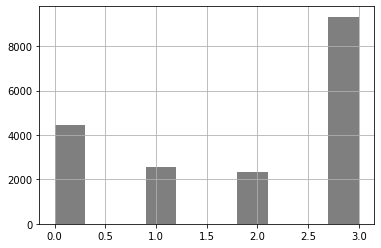

In [27]:
cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01305	valid_1's rmse: 1.03181
[200]	training's rmse: 0.945222	valid_1's rmse: 0.984044
[300]	training's rmse: 0.911401	valid_1's rmse: 0.968491
[400]	training's rmse: 0.888672	valid_1's rmse: 0.962504
[500]	training's rmse: 0.870158	valid_1's rmse: 0.959807
[600]	training's rmse: 0.854535	valid_1's rmse: 0.958539
[700]	training's rmse: 0.84055	valid_1's rmse: 0.957503
[800]	training's rmse: 0.827614	valid_1's rmse: 0.957132
[900]	training's rmse: 0.815627	valid_1's rmse: 0.957259
Early stopping, best iteration is:
[803]	training's rmse: 0.827204	valid_1's rmse: 0.957065
Partial score of fold 0 is: 0.5929414645971569
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01249	valid_1's rmse: 1.0395
[200]	training's rmse: 0.94475	valid_1's rmse: 0.992346
[300]	training's rmse: 0.91194	valid_1's rmse: 0.97736
[400]	training's rmse: 0.889299	valid_1's rmse: 0.970344
[500]	training's rmse: 0.870961	valid_1's rmse: 0.966998
[600]	training's rmse: 0.855208	valid_1's rmse: 0.965146
[700]	training's rmse: 0.840887	valid_1's rmse: 0.964
[800]	training's rmse: 0.82792	valid_1's rmse: 0.963541
[900]	training's rmse: 0.815865	valid_1's rmse: 0.963003
[1000]	training's rmse: 0.804572	valid_1's rmse: 0.962553
[1100]	training's rmse: 0.793784	valid_1's rmse: 0.962354
Early stopping, best iteration is:
[1062]	training's rmse: 0.797796	valid_1's rmse: 0.962251
Partial score of fold 1 is: 0.6000106301954551
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01729	valid_1's rmse: 1.02876
[200]	training's rmse: 0.949928	valid_1's rmse: 0.974635
[300]	training's rmse: 0.917069	valid_1's rmse: 0.956151
[400]	training's rmse: 0.894212	valid_1's rmse: 0.948547
[500]	training's rmse: 0.876171	valid_1's rmse: 0.945127
[600]	training's rmse: 0.860469	valid_1's rmse: 0.943162
[700]	training's rmse: 0.846484	valid_1's rmse: 0.941769
[800]	training's rmse: 0.83338	valid_1's rmse: 0.941282
[900]	training's rmse: 0.821001	valid_1's rmse: 0.940844
[1000]	training's rmse: 0.80934	valid_1's rmse: 0.940817
Early stopping, best iteration is:
[955]	training's rmse: 0.814463	valid_1's rmse: 0.940695
Partial score of fold 2 is: 0.6215984724446693
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01168	valid_1's rmse: 1.03453
[200]	training's rmse: 0.944654	valid_1's rmse: 0.987451
[300]	training's rmse: 0.912303	valid_1's rmse: 0.971961
[400]	training's rmse: 0.889723	valid_1's rmse: 0.964749
[500]	training's rmse: 0.871475	valid_1's rmse: 0.961265
[600]	training's rmse: 0.855809	valid_1's rmse: 0.958868
[700]	training's rmse: 0.841751	valid_1's rmse: 0.957513
[800]	training's rmse: 0.828822	valid_1's rmse: 0.956187
[900]	training's rmse: 0.816566	valid_1's rmse: 0.95549
[1000]	training's rmse: 0.805144	valid_1's rmse: 0.955214
[1100]	training's rmse: 0.794316	valid_1's rmse: 0.954884
Early stopping, best iteration is:
[1075]	training's rmse: 0.796979	valid_1's rmse: 0.954803
Partial score of fold 3 is: 0.6076124342224567
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.01306	valid_1's rmse: 1.03289
[200]	training's rmse: 0.944512	valid_1's rmse: 0.985525
[300]	training's rmse: 0.911071	valid_1's rmse: 0.97214
[400]	training's rmse: 0.888318	valid_1's rmse: 0.966954
[500]	training's rmse: 0.869991	valid_1's rmse: 0.964468
[600]	training's rmse: 0.854081	valid_1's rmse: 0.96294
[700]	training's rmse: 0.839852	valid_1's rmse: 0.962457
[800]	training's rmse: 0.826981	valid_1's rmse: 0.962594
Early stopping, best iteration is:
[715]	training's rmse: 0.837874	valid_1's rmse: 0.96232
Partial score of fold 4 is: 0.5944376294904521
Our oof cohen kappa score is:  0.6025067808669881
[0]	train-rmse:1.8343	val-rmse:1.83576
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[100]	train-rmse:0.990514	val-rmse:1.14397
[200]	train-rmse:0.708751	val-rmse:1.00378
[300]	train-rmse:0.593842	val-rmse:0.980222
[400]	train-rmse:0.532215	val-rmse:0.976547
[500]	train-rmse:0.493079	val-rmse:0.976451
[600]	train-rmse:0.466239	val-rmse:0.976878
Stopping. Best iteration:
[509]	train-rmse:0.49042	val-rmse:0.976361

Partial score of fold 0 is: 0.5780717661210506
[0]	train-rmse:1.83433	val-rmse:1.8355
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.989351	val-rmse:1.14073
[200]	train-rmse:0.713247	val-rmse:1.00398
[300]	train-rmse:0.593934	val-rmse:0.980075
[400]	train-rmse:0.526608	val-rmse:0.975913
[500]	train-rmse:0.488021	val-rmse:0.975284
Stopping. Best iteration:
[472]	train-rmse:0.497045	val-rmse:0.975212

Partial score of fold 1 is: 0.5838636262366934
[0]	train-rmse:1.83452	val-rmse:1.83527
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.992766	val-rmse:1.12985
[200]	train-rmse:0.717236	val-rmse:0.986409
[300]	train-rmse:0.604476	val-rmse:0.961644
[400]	train-rmse:0.543962	val-rmse:0.958755
[500]	train-rmse:0.511792	val-rmse:0.958973
Stopping. Best iteration:
[414]	train-rmse:0.538348	val-rmse:0.958578

Partial score of fold 2 is: 0.5931657046042409
[0]	train-rmse:1.83445	val-rmse:1.83577
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.984832	val-rmse:1.12959
[200]	train-rmse:0.701668	val-rmse:0.987725
[300]	train-rmse:0.58585	val-rmse:0.965562
[400]	train-rmse:0.525423	val-rmse:0.962632
[500]	train-rmse:0.487095	val-rmse:0.962826
Stopping. Best iteration:
[403]	train-rmse:0.523978	val-rmse:0.962597

Partial score of fold 3 is: 0.5919871575539102
[0]	train-rmse:1.83455	val-rmse:1.83526
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.988696	val-rmse:1.13803
[200]	train-rmse:0.709556	val-rmse:0.998482
[300]	train-rmse:0.595364	val-rmse:0.974106
[400]	train-rmse:0.536609	val-rmse:0.971258
[500]	train-rmse:0.498554	val-rmse:0.972259
Stopping. Best iteration:
[411]	train-rmse:0.531903	val-rmse:0.971133

Partial score of fold 4 is: 0.5839058215568564
Our oof cohen kappa score is:  0.5862517587455798

(18690, 370)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               74200     
_________________________________________________________________
layer_normalization (LayerNo (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0 

Epoch 24/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.9234
Epoch 00024: val_loss did not improve from 0.98295
14952/14952 [==============================] - 2s 160us/sample - loss: 0.9241 - val_loss: 0.9927
Epoch 25/100
14880/14952 [============================>.] - ETA: 0s - loss: 0.9254
Epoch 00025: val_loss improved from 0.98295 to 0.97939, saving model to nn_model.w8
14952/14952 [==============================] - 2s 159us/sample - loss: 0.9251 - val_loss: 0.9794
Epoch 26/100
14944/14952 [============================>.] - ETA: 0s - loss: 0.9198
Epoch 00026: val_loss did not improve from 0.97939
14952/14952 [==============================] - 2s 157us/sample - loss: 0.9195 - val_loss: 0.9910
Epoch 27/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.9055
Epoch 00027: val_loss did not improve from 0.97939
14952/14952 [==============================] - 2s 156us/sample - loss: 0.9068 - val_loss: 1.0099
Epoch 28/100
14880/14952 [=================

Epoch 2/100
14656/14952 [============================>.] - ETA: 0s - loss: 1.4832
Epoch 00002: val_loss improved from 1.13469 to 1.05232, saving model to nn_model.w8
14952/14952 [==============================] - 2s 158us/sample - loss: 1.4809 - val_loss: 1.0523
Epoch 3/100
14816/14952 [============================>.] - ETA: 0s - loss: 1.3216
Epoch 00003: val_loss improved from 1.05232 to 1.02561, saving model to nn_model.w8
14952/14952 [==============================] - 2s 156us/sample - loss: 1.3216 - val_loss: 1.0256
Epoch 4/100
14880/14952 [============================>.] - ETA: 0s - loss: 1.2321
Epoch 00004: val_loss improved from 1.02561 to 1.01615, saving model to nn_model.w8
14952/14952 [==============================] - 2s 159us/sample - loss: 1.2340 - val_loss: 1.0162
Epoch 5/100
14624/14952 [============================>.] - ETA: 0s - loss: 1.1700
Epoch 00005: val_loss did not improve from 1.01615
14952/14952 [==============================] - 2s 158us/sample - loss: 1.1705 

Epoch 36/100
14944/14952 [============================>.] - ETA: 0s - loss: 0.8378
Epoch 00036: val_loss did not improve from 0.95289
14952/14952 [==============================] - 2s 167us/sample - loss: 0.8384 - val_loss: 0.9834
Epoch 37/100
14944/14952 [============================>.] - ETA: 0s - loss: 0.8367
Epoch 00037: val_loss did not improve from 0.95289
14952/14952 [==============================] - 2s 162us/sample - loss: 0.8375 - val_loss: 0.9806
Epoch 38/100
14816/14952 [============================>.] - ETA: 0s - loss: 0.8345
Epoch 00038: val_loss did not improve from 0.95289
14952/14952 [==============================] - 2s 158us/sample - loss: 0.8328 - val_loss: 0.9851
Epoch 39/100
14848/14952 [============================>.] - ETA: 0s - loss: 0.8285
Epoch 00039: val_loss did not improve from 0.95289
14952/14952 [==============================] - 2s 163us/sample - loss: 0.8290 - val_loss: 1.0021
Epoch 40/100
14912/14952 [============================>.] - ETA: 0s - loss: 

Epoch 17/100
14688/14952 [============================>.] - ETA: 0s - loss: 0.9933
Epoch 00017: val_loss did not improve from 0.94339
14952/14952 [==============================] - 2s 164us/sample - loss: 0.9943 - val_loss: 0.9637
Epoch 18/100
14752/14952 [============================>.] - ETA: 0s - loss: 0.9920
Epoch 00018: val_loss improved from 0.94339 to 0.93380, saving model to nn_model.w8
14952/14952 [==============================] - 2s 160us/sample - loss: 0.9916 - val_loss: 0.9338
Epoch 19/100
14656/14952 [============================>.] - ETA: 0s - loss: 0.9795
Epoch 00019: val_loss did not improve from 0.93380
14952/14952 [==============================] - 2s 161us/sample - loss: 0.9814 - val_loss: 0.9396
Epoch 20/100
14752/14952 [============================>.] - ETA: 0s - loss: 0.9741
Epoch 00020: val_loss did not improve from 0.93380
14952/14952 [==============================] - 2s 161us/sample - loss: 0.9743 - val_loss: 0.9391
Epoch 21/100
14912/14952 [=================

Epoch 1/100
14784/14952 [============================>.] - ETA: 0s - loss: 2.0716
Epoch 00001: val_loss improved from inf to 1.21645, saving model to nn_model.w8
14952/14952 [==============================] - 3s 216us/sample - loss: 2.0654 - val_loss: 1.2165
Epoch 2/100
14656/14952 [============================>.] - ETA: 0s - loss: 1.4540
Epoch 00002: val_loss improved from 1.21645 to 1.14086, saving model to nn_model.w8
14952/14952 [==============================] - 2s 160us/sample - loss: 1.4530 - val_loss: 1.1409
Epoch 3/100
14688/14952 [============================>.] - ETA: 0s - loss: 1.3210
Epoch 00003: val_loss improved from 1.14086 to 1.11989, saving model to nn_model.w8
14952/14952 [==============================] - 2s 158us/sample - loss: 1.3227 - val_loss: 1.1199
Epoch 4/100
14912/14952 [============================>.] - ETA: 0s - loss: 1.2428
Epoch 00004: val_loss improved from 1.11989 to 1.08132, saving model to nn_model.w8
14952/14952 [==============================] - 2s

Epoch 35/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.8494
Epoch 00035: val_loss did not improve from 0.98896
14952/14952 [==============================] - 2s 160us/sample - loss: 0.8494 - val_loss: 1.0202
Epoch 36/100
14944/14952 [============================>.] - ETA: 0s - loss: 0.8513
Epoch 00036: val_loss did not improve from 0.98896
14952/14952 [==============================] - 2s 164us/sample - loss: 0.8511 - val_loss: 1.0147
Epoch 37/100
14816/14952 [============================>.] - ETA: 0s - loss: 0.8498
Epoch 00037: val_loss did not improve from 0.98896
14952/14952 [==============================] - 2s 164us/sample - loss: 0.8493 - val_loss: 1.0215
Epoch 38/100
14752/14952 [============================>.] - ETA: 0s - loss: 0.8316
Epoch 00038: val_loss did not improve from 0.98896
14952/14952 [==============================] - 2s 163us/sample - loss: 0.8305 - val_loss: 1.0300
Epoch 39/100
14784/14952 [============================>.] - ETA: 0s - loss: 

Epoch 10/100
14880/14952 [============================>.] - ETA: 0s - loss: 1.0788
Epoch 00010: val_loss did not improve from 0.98773
14952/14952 [==============================] - 2s 162us/sample - loss: 1.0790 - val_loss: 0.9919
Epoch 11/100
14592/14952 [============================>.] - ETA: 0s - loss: 1.0745
Epoch 00011: val_loss improved from 0.98773 to 0.96237, saving model to nn_model.w8
14952/14952 [==============================] - 2s 158us/sample - loss: 1.0743 - val_loss: 0.9624
Epoch 12/100
14944/14952 [============================>.] - ETA: 0s - loss: 1.0516
Epoch 00012: val_loss did not improve from 0.96237
14952/14952 [==============================] - 2s 159us/sample - loss: 1.0516 - val_loss: 0.9899
Epoch 13/100
14816/14952 [============================>.] - ETA: 0s - loss: 1.0462
Epoch 00013: val_loss did not improve from 0.96237
14952/14952 [==============================] - 2s 159us/sample - loss: 1.0461 - val_loss: 0.9667
Epoch 14/100
14784/14952 [=================

14624/14952 [============================>.] - ETA: 0s - loss: 0.8119
Epoch 00044: val_loss did not improve from 0.93843
14952/14952 [==============================] - 2s 161us/sample - loss: 0.8120 - val_loss: 0.9516
Epoch 45/100
14720/14952 [============================>.] - ETA: 0s - loss: 0.8168
Epoch 00045: val_loss did not improve from 0.93843
14952/14952 [==============================] - 2s 159us/sample - loss: 0.8184 - val_loss: 0.9613
Partial score of fold 4 is: 0.614134434333335
Our oof cohen kappa score is:  0.6036117627722235


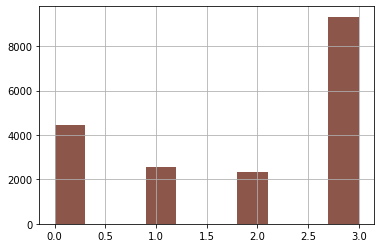

In [28]:
# cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [29]:
weights = {'lbg': 0.35, 'cat': 0.25, 'xgb': 0.25, 'nn': 0.15}

final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
#final_pred = cnn_model.y_pred
print(final_pred.shape)

(1000,)


In [30]:
pd.DataFrame([(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)], columns=['lgb', 'cat', 'xgb', 'nn']).head(50)

,lgb,cat,xgb,nn
0,2.51,2.48,2.63,2.65
1,2.87,2.81,2.89,2.76
2,2.74,2.65,2.85,2.68
3,2.29,2.32,2.27,2.69
4,1.79,1.90,1.90,2.41
5,2.63,2.72,2.74,2.77
6,1.61,1.40,1.38,2.22
7,1.78,1.91,1.92,2.02
8,0.05,0.06,0.12,0.17
9,0.70,1.04,0.35,0.79


{0: 0.6744025399834886, 1: 1.2569525974994633, 2: 1.677849110896383}


3    0.499
0    0.239
1    0.137
2    0.125
Name: accuracy_group, dtype: float64

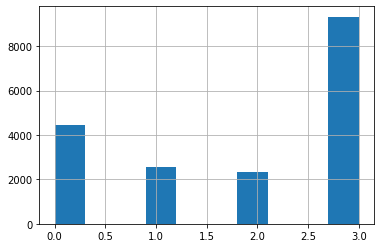

In [31]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)

3    0.498
0    0.239
1    0.137
2    0.126